In [21]:
import os
import sys
import time
from datetime import datetime
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from model_settings import ms
import matplotlib.pyplot as plt
os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
sys.path.append(os.path.join(notebook_dir,'historical_data','historical_generation'))
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


##################
# training start #
##################

Fri Oct 11 18:13:33 2024



# Loading data

In [22]:
from HDF_collection import contracts
dataset = contracts.copy()

In [23]:
pd.Series(np.random.normal(scale=0.15,size=10000)).describe()

count   10000.00000
mean       -0.00046
std         0.15042
min        -0.66053
25%        -0.10234
50%         0.00131
75%         0.10037
max         0.58907
dtype: float64

# Data Cleaning

## Checking data

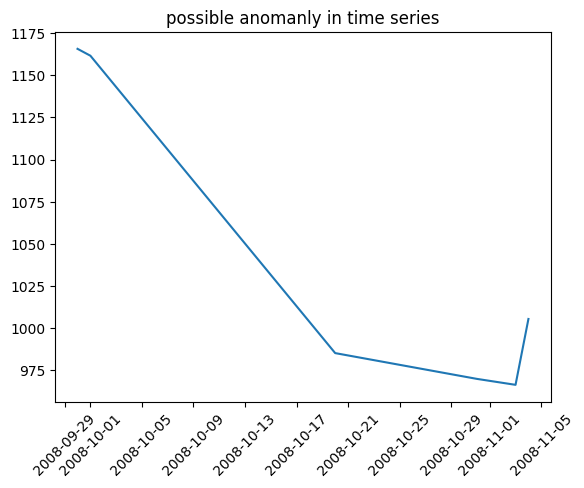

<Figure size 640x480 with 0 Axes>

In [24]:
check = dataset.copy().set_index('calculation_date').sort_index(ascending=True)
check = check[
    (check.index>datetime(2008,9,29))
    &
    (check.index<datetime(2008,11,5))
]
check
plt.figure()
plt.plot(check['spot_price'])
plt.xticks(rotation=45)
plt.title('possible anomanly in time series')
plt.show()
plt.clf()

## Filtering data

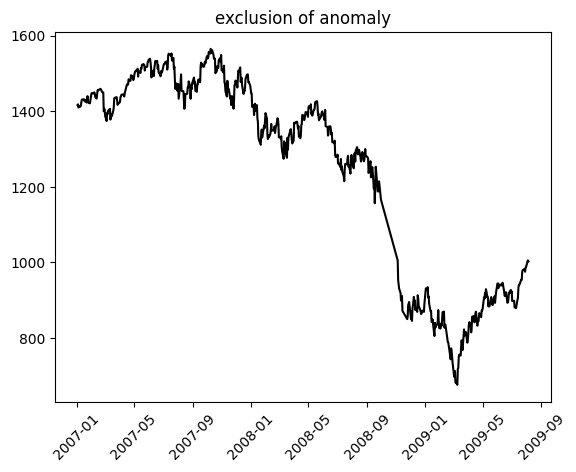

                   calculation_date  spot_price  strike_price    barrier  \
mean  2008-05-25 22:38:58.503472640  1234.98933    1234.24034 1235.08227   
min             2007-01-03 00:00:00   676.03000     608.42700  338.01500   
25%             2007-10-19 00:00:00   920.17000     941.01543  860.28030   
50%             2008-05-19 00:00:00  1331.14000    1316.67569 1185.47345   
75%             2009-01-09 00:00:00  1466.84000    1450.17939 1556.21255   
max             2009-08-05 00:00:00  1565.18000    1721.69800 2347.77000   
std                             NaN   264.16961     273.87156  471.42267   

      days_to_maturity  barrier_price  rebate  dividend_rate  risk_free_rate  \
mean         329.03423       53.28322 0.00000        0.02320         0.04000   
min           60.00000        0.00000 0.00000        0.01780         0.04000   
25%           90.00000        3.52941 0.00000        0.01915         0.04000   
50%          360.00000       33.54887 0.00000        0.02206         0.

<Figure size 640x480 with 0 Axes>

In [25]:
dataset = dataset.set_index('calculation_date')
dataset = dataset[
    ~(
    (dataset.index>datetime(2008,9,30))
        &
    (dataset.index<datetime(2008,11,4))
    )
]
plt.figure()
plt.plot(dataset['spot_price'].copy().drop_duplicates(),color='black')
plt.xticks(rotation=45)
plt.title('exclusion of anomaly')
plt.show()
plt.clf()
dataset = dataset.reset_index()
print(dataset.describe().iloc[1:,:])
print(f"\ncount {dataset.shape[0]}")

## Train/test split

In [5]:
from convsklearn import barrier_trainer
bt = barrier_trainer

test size: 1.0%
random state: None
maximum iterations: 1000

target: 
observed_price

features: 
['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier', 'barrier_type_name', 'w']

feature transformer(s):
('StandardScaler', StandardScaler(), ['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier'])

('OneHotEncoder', OneHotEncoder(sparse_output=False), ['barrier_type_name', 'w'])

target transformer(s):
StandardScaler()



In [6]:
unique_dates = dataset['calculation_date'].sort_values(
    ascending=True).unique().tolist()
filter_date = unique_dates[int(0.85*len(unique_dates))]

train_data = dataset[
    (
      # (dataset['calculation_date']>=datetime(2007,1,1))
      #  &
      (dataset['calculation_date']<=filter_date)
    )
].copy()

test_data = dataset[
    (
        (dataset['calculation_date']>filter_date)
        # &
        # (dataset['calculation_date']<=datetime(2012,12,31))
    )
].copy()

# Preprocessing

In [7]:
train_X, train_y, test_X, test_y = bt.get_train_test_arrays(
    train_data, test_data)
preprocessor = bt.preprocess()
train_startdate = train_data.describe()['calculation_date']['min'].strftime('%A, %Y-%m-%d')
train_enddate = train_data.describe()['calculation_date']['max'].strftime('%A, %Y-%m-%d')
print(f"\ntraining from\n{train_startdate}\nto\n{train_enddate}\n")


training from
Wednesday, 2007-01-03
to
Wednesday, 2009-03-25



In [8]:
print(f"\n{train_data.dtypes}")
test_train_ratio = test_data.describe(
    ).iloc[0,0]/train_data.describe().iloc[0,0]

print(f"\ntrain/test: {int(round((1-test_train_ratio)*100,0))}/"
      +str(int(round(test_train_ratio*100,0))))


calculation_date     datetime64[ns]
spot_price                  float64
strike_price                float64
barrier                     float64
days_to_maturity              int64
barrier_price               float64
updown                       object
outin                        object
w                            object
barrier_type_name            object
rebate                      float64
dividend_rate               float64
risk_free_rate              float64
theta                       float64
kappa                       float64
rho                         float64
eta                         float64
v0                          float64
expiration_date      datetime64[ns]
moneyness                   float64
observed_price              float64
dtype: object

train/test: 81/19


# Training

In [9]:
model_fit, runtime, specs = bt.run_dnn(preprocessor,train_X,train_y)
train_end = time.time()
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")


training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: adaptive
activation: relu
solver: sgd
alpha: 0.0001

cpu: 1014.2439494132996


# Testing

In [10]:
test_data.describe()

,calculation_date,spot_price,strike_price,barrier,days_to_maturity,barrier_price,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,expiration_date,moneyness,observed_price
count,1071973,1071973.00000,1071973.00000,1071973.00000,1071973.00000,1071973.00000,1071973.00000,1071973.00000,1071973.00000,1071973.00000,1071973.00000,1071973.00000,1071973.00000,1071973.00000,1071973,1071973.00000,1071973.00000
mean,2009-05-31 07:38:53.439741696,902.61139,902.37588,903.47715,326.59024,47.56622,0.00000,0.02543,0.04000,0.09749,5.63177,-0.99570,0.20217,0.07706,2010-04-22 21:48:50.228653312,2.08573,47.57189
min,2009-03-26 00:00:00,787.62000,708.85800,393.81000,60.00000,0.00000,0.00000,0.02262,0.04000,0.06951,2.05280,-1.00000,0.15451,0.03432,2009-05-25 00:00:00,-0.94575,0.00000
25%,2009-04-28 00:00:00,869.57000,850.25261,673.01810,90.00000,4.52670,0.00000,0.02421,0.04000,0.08075,4.98874,-1.00000,0.18488,0.05176,2009-09-18 00:00:00,-0.75021,4.52525
50%,2009-06-01 00:00:00,906.67000,900.49653,902.67045,360.00000,31.95183,0.00000,0.02514,0.04000,0.08698,5.54557,-0.99999,0.19700,0.06805,2010-03-22 00:00:00,-0.05699,31.95609
75%,2009-07-02 00:00:00,939.09000,953.52043,1138.59285,540.00000,82.23192,0.00000,0.02652,0.04000,0.12124,5.98426,-0.99995,0.22056,0.10292,2010-11-24 00:00:00,1.86218,82.23981
max,2009-08-05 00:00:00,1005.38000,1105.91800,1508.07000,720.00000,210.76771,0.00000,0.02983,0.04000,0.15119,8.79712,-0.92557,0.26985,0.17432,2011-07-26 00:00:00,17.43197,210.71109
std,NaN,48.37048,71.68792,285.23774,241.39909,48.15583,0.00000,0.00167,0.00000,0.02389,1.03795,0.01238,0.02645,0.03313,NaN,4.47396,48.15043


In [11]:
insample, outsample, errors = bt.test_prediction_accuracy(
        model_fit,
        test_data,
        train_data
        )


in sample:
     RSME: 4.895752747825027
     MAE: 3.421006643540218

out of sample:
     RSME: 6.866558350365198
     MAE: 5.150720789712467


# Saving

In [12]:
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H-%M-%S"))
file_tag = str(train_end_tag + " " + specs[0] )
os.chdir(os.path.join(notebook_dir,'trained_models'))
files_dir = os.path.join(
    notebook_dir,'trained_models','trained_models',
    file_tag)

if Path(files_dir).exists():
    pass
else:
    os.mkdir(files_dir)

file_dir = os.path.join(files_dir,file_tag)

S = np.sort(train_data['spot_price'].unique())
K = np.sort(train_data['strike_price'].unique())
T = np.sort(train_data['days_to_maturity'].unique())
W = np.sort(train_data['w'].unique())
n_calls = train_data[train_data['w']=='call'].shape[0]
n_puts = train_data[train_data['w']=='put'].shape[0]
insample.to_csv(f"{file_dir} insample.csv")
outsample.to_csv(f"{file_dir} outsample.csv")
joblib.dump(model_fit,str(f"{file_dir}.pkl"))
pd.set_option("display.max_columns",None)

with open(f'{file_dir}.txt', 'w') as file:
    file.write(train_start_tag)
    file.write(f"\nspot(s):\n{S}")
    file.write(f"\n\nstrikes:\n{K}\n")
    file.write(f"\nmaturities:\n{T}\n")
    file.write(f"\ntypes:\n{W}\n")
    try:
        file.write(f"\n{train_data['barrier_type_name'].unique()}")
    except Exception:
        pass
    file.write("")
    file.write(f"\nnumber of calls, puts:\n{n_calls},{n_puts}\n")
    file.write(f"\ntotal prices:\n{train_data.shape[0]}\n")
    for spec in specs:
        file.write(f"{spec}\n")
    file.write("#"*17+"\n# training data #\n"+"#"*17+
          f"\n{train_data.describe()}\n")
    file.write("#"*13+"\n# test data #\n"+"#"*13+
          f"\n{test_data.describe()}\n")
    file.write(f"\n{dataset.dtypes}")
    file.write(
        f"\nin sample results:"
        f"\n     RMSE: {errors['insample_RMSE']}"
        f"\n     MAE: {errors['insample_MAE']}\n"
        f"\nout of sample results:"
        f"\n     RMSE: {errors['outofsample_RMSE']}"
        f"\n     MAE: {errors['outofsample_MAE']}\n"
        )
    file.write("\nfeatures:\n")
    for feature in bt.feature_set:
        file.write(f"     {feature}\n")
    file.write(f"\ntarget: {bt.target_name}\n")
    file.write(f"\ncpu: {train_runtime}\n")
    file.write(datetime.fromtimestamp(train_end).strftime('%c'))